In [1]:
"""
Dataset Text Accessibility Ranking Analysis
==========================================

This script analyzes which datasets are most suitable for accessibility
by ranking datasets based on their text quality and simplicity scores.

Weighting Strategy (Equal):
- Text Quality: 50% (content effectiveness)
- Text Simplicity: 50% (cognitive accessibility)

Key Features:
- Handles both _IAA (multi-expert) and single-expert images
- Averages scores when multiple experts rate the same image
- Maps images to datasets using CSV mapping file
- Provides statistical confidence measures
- Separate overall score analysis for reference

Author: Dataset Accessibility Analysis
Date: June 2025
"""

import json
import pandas as pd
import numpy as np
from pathlib import Path
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURATION
# ============================================================================

# File paths (update these to match your system)
ANNOTATION_DIR = r"C:\Users\SouayedBelkiss\OneDrive - gae\Desktop\Thesis\annotation_analysis\expert work"
MAPPING_DIR = r"C:\Users\SouayedBelkiss\OneDrive - gae\Desktop\Thesis\annotation_analysis\required files"

# File mappings
ANNOTATION_FILES = {
    'Expert_A': 'alexa_annotations.json',
    'Expert_K': 'katrin_annotations.json', 
    'Expert_L': 'luisa_annotations.json',
    'Expert_M': 'martin_annotations.json'
}

MAPPING_FILE = 'renamed_images_mapping.csv'

# Text accessibility dimensions (equal weighting)
TEXT_ACCESSIBILITY_DIMENSIONS = {
    'txt_quality': {'scale_max': 15, 'display_name': 'Text Quality', 'weight': 0.50},
    'txt_simplicity': {'scale_max': 15, 'display_name': 'Text Simplicity', 'weight': 0.50}
}

# All dimensions for reference
ALL_DIMENSIONS = {
    'img_simplicity': {'scale_max': 15, 'display_name': 'Image Simplicity'},
    'img_quality': {'scale_max': 15, 'display_name': 'Image Quality'},
    'txt_simplicity': {'scale_max': 15, 'display_name': 'Text Simplicity'},
    'txt_quality': {'scale_max': 15, 'display_name': 'Text Quality'},
    'ethics': {'scale_max': 20, 'display_name': 'Ethics'},
    'txt_img_align': {'scale_max': 20, 'display_name': 'Text-Image Alignment'}
}

# ============================================================================
# DATA LOADING FUNCTIONS
# ============================================================================

def load_dataset_mapping():
    """Load the CSV mapping file to link images to datasets."""
    print("Loading dataset mapping...")
    
    mapping_path = Path(MAPPING_DIR) / MAPPING_FILE
    
    try:
        df_mapping = pd.read_csv(mapping_path)
        print(f"✓ Loaded mapping for {len(df_mapping)} images")
        
        # Create lookup: new_filename -> dataset
        dataset_mapping = {}
        for _, row in df_mapping.iterrows():
            new_filename = row['new_filename']
            dataset = row['dataset'].strip()
            dataset_mapping[new_filename] = dataset
        
        # Show dataset distribution
        dataset_counts = df_mapping['dataset'].value_counts()
        print(f"Dataset distribution in mapping:")
        for dataset, count in dataset_counts.items():
            print(f"  {dataset}: {count} images")
        
        # Get unique datasets
        unique_datasets = sorted(df_mapping['dataset'].unique())
        print(f"\nUnique datasets found: {len(unique_datasets)}")
        for dataset in unique_datasets:
            print(f"  • {dataset}")
        
        return dataset_mapping, unique_datasets
        
    except FileNotFoundError:
        print(f"✗ ERROR: Could not find {MAPPING_FILE}")
        return None, None
    except Exception as e:
        print(f"✗ ERROR loading mapping: {e}")
        return None, None

def load_expert_annotations(expert_name, filename):
    """Load and parse annotations for one expert."""
    filepath = Path(ANNOTATION_DIR) / filename
    
    with open(filepath, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    annotations = []
    
    for record in data:
        if record['annotations']:
            annotation = record['annotations'][0]
            result = annotation['result']
            
            # Extract image info
            image_filename = record['data'].get('original_filename', 'unknown')
            
            # Extract dimension scores
            scores = {'expert': expert_name, 'image': image_filename}
            
            for item in result:
                if item['type'] == 'number' and item['from_name'] in ALL_DIMENSIONS:
                    scores[item['from_name']] = item['value']['number']
            
            # Calculate total score (sum of all dimensions)
            total_score = sum([scores.get(dim, 0) for dim in ALL_DIMENSIONS.keys()])
            scores['total_score'] = total_score
            
            annotations.append(scores)
    
    return pd.DataFrame(annotations)

def load_all_expert_data():
    """Load annotations from all experts."""
    print("\nLoading expert annotations...")
    
    all_dataframes = []
    
    for expert_name, filename in ANNOTATION_FILES.items():
        print(f"Loading {expert_name}...")
        df = load_expert_annotations(expert_name, filename)
        all_dataframes.append(df)
        print(f"  - Loaded {len(df)} annotations")
    
    # Combine all data
    all_data = pd.concat(all_dataframes, ignore_index=True)
    print(f"\nTotal annotations loaded: {len(all_data)}")
    
    return all_data

# ============================================================================
# DATASET MAPPING AND AGGREGATION
# ============================================================================

def map_images_to_datasets(all_data, dataset_mapping):
    """Map image annotations to their datasets and handle multi-expert ratings."""
    print("\nMapping images to datasets and aggregating multi-expert ratings...")
    
    # Add dataset column
    def get_dataset_for_image(image_filename):
        # Handle _IAA images by removing suffix
        base_filename = image_filename.replace('_IAA', '')
        return dataset_mapping.get(base_filename, 'unknown')
    
    all_data['dataset'] = all_data['image'].apply(get_dataset_for_image)
    
    # Filter out unknown datasets
    valid_data = all_data[all_data['dataset'] != 'unknown'].copy()
    print(f"Images successfully mapped to datasets: {len(valid_data)}")
    print(f"Images with unknown datasets: {len(all_data) - len(valid_data)}")
    
    # Identify multi-expert images
    image_expert_counts = valid_data.groupby('image')['expert'].count()
    multi_expert_images = image_expert_counts[image_expert_counts > 1]
    
    print(f"\nMulti-expert annotation summary:")
    print(f"  Total unique images: {len(image_expert_counts)}")
    print(f"  Images with multiple experts: {len(multi_expert_images)}")
    print(f"  Images with single expert: {len(image_expert_counts) - len(multi_expert_images)}")
    
    # Aggregate scores (average when multiple experts rate same image)
    aggregated_data = []
    
    for image_name, group in valid_data.groupby('image'):
        # Get the dataset (should be same for all experts rating this image)
        dataset = group['dataset'].iloc[0]
        
        # Calculate aggregated scores
        agg_scores = {'image': image_name, 'dataset': dataset, 'num_experts': len(group)}
        
        # Average all dimension scores
        for dim in ALL_DIMENSIONS.keys():
            if dim in group.columns:
                dim_scores = group[dim].dropna()
                if len(dim_scores) > 0:
                    agg_scores[dim] = dim_scores.mean()
                    agg_scores[f'{dim}_std'] = dim_scores.std() if len(dim_scores) > 1 else 0
        
        # Average total score
        total_scores = group['total_score'].dropna()
        if len(total_scores) > 0:
            agg_scores['total_score'] = total_scores.mean()
            agg_scores['total_score_std'] = total_scores.std() if len(total_scores) > 1 else 0
        
        aggregated_data.append(agg_scores)
    
    aggregated_df = pd.DataFrame(aggregated_data)
    print(f"Aggregated dataset: {len(aggregated_df)} unique images")
    
    return aggregated_df

# ============================================================================
# TEXT ACCESSIBILITY SCORE CALCULATION
# ============================================================================

def calculate_text_accessibility_scores(aggregated_df):
    """Calculate weighted text accessibility scores for each image."""
    print("\nCalculating text accessibility scores...")
    
    text_accessibility_scores = []
    
    for _, row in aggregated_df.iterrows():
        # Calculate weighted text accessibility score
        weighted_score = 0
        max_possible_score = 0
        dimension_scores = {}
        
        for dim, config in TEXT_ACCESSIBILITY_DIMENSIONS.items():
            if dim in row and pd.notna(row[dim]):
                score = row[dim]
                max_score = config['scale_max']
                weight = config['weight']
                
                # Normalize to 0-1 scale, then apply weight
                normalized_score = score / max_score
                weighted_contribution = normalized_score * weight
                
                weighted_score += weighted_contribution
                max_possible_score += weight
                
                dimension_scores[dim] = {
                    'raw_score': score,
                    'max_score': max_score,
                    'normalized': normalized_score,
                    'weighted_contribution': weighted_contribution
                }
        
        # Convert to 0-100 scale
        if max_possible_score > 0:
            text_accessibility_score = (weighted_score / max_possible_score) * 100
        else:
            text_accessibility_score = 0
        
        text_accessibility_scores.append({
            'image': row['image'],
            'dataset': row['dataset'],
            'num_experts': row['num_experts'],
            'text_accessibility_score': text_accessibility_score,
            'total_score': row.get('total_score', 0),
            'dimension_scores': dimension_scores
        })
    
    return pd.DataFrame(text_accessibility_scores)

# ============================================================================
# DATASET RANKING ANALYSIS
# ============================================================================

def rank_datasets_by_text_accessibility(text_accessibility_df, unique_datasets):
    """Rank the datasets by their text accessibility scores."""
    print(f"\n{'='*80}")
    print("DATASET TEXT ACCESSIBILITY RANKING ANALYSIS")
    print(f"{'='*80}")
    print("Weighting: Text Quality (50%), Text Simplicity (50%)")
    
    # Calculate dataset statistics
    dataset_stats = []
    
    for dataset in unique_datasets:
        dataset_data = text_accessibility_df[text_accessibility_df['dataset'] == dataset]
        
        if len(dataset_data) == 0:
            # No data for this dataset
            stats = {
                'Dataset': dataset,
                'N_Images': 0,
                'Mean_Text_Accessibility_Score': 0,
                'Std_Text_Accessibility_Score': 0,
                'Mean_Total_Score': 0,
                'Std_Total_Score': 0,
                'Multi_Expert_Images': 0,
                'Confidence': 'No Data'
            }
        else:
            # Calculate statistics
            text_acc_scores = dataset_data['text_accessibility_score']
            total_scores = dataset_data['total_score']
            multi_expert_count = (dataset_data['num_experts'] > 1).sum()
            
            # Confidence level based on sample size and multi-expert coverage
            n_images = len(dataset_data)
            if n_images >= 20 and multi_expert_count >= 5:
                confidence = 'High'
            elif n_images >= 10 and multi_expert_count >= 2:
                confidence = 'Medium'
            elif n_images >= 5:
                confidence = 'Low'
            else:
                confidence = 'Very Low'
            
            stats = {
                'Dataset': dataset,
                'N_Images': n_images,
                'Mean_Text_Accessibility_Score': text_acc_scores.mean(),
                'Std_Text_Accessibility_Score': text_acc_scores.std(),
                'Mean_Total_Score': total_scores.mean(),
                'Std_Total_Score': total_scores.std(),
                'Multi_Expert_Images': multi_expert_count,
                'Confidence': confidence
            }
        
        dataset_stats.append(stats)
    
    # Create results dataframe
    results_df = pd.DataFrame(dataset_stats)
    
    # Sort by text accessibility score (descending)
    results_df = results_df.sort_values('Mean_Text_Accessibility_Score', ascending=False)
    
    # Add ranking
    results_df['Rank'] = range(1, len(results_df) + 1)
    
    # Round numerical columns
    numeric_cols = ['Mean_Text_Accessibility_Score', 'Std_Text_Accessibility_Score', 
                   'Mean_Total_Score', 'Std_Total_Score']
    results_df[numeric_cols] = results_df[numeric_cols].round(2)
    
    return results_df

def print_detailed_dataset_ranking(results_df):
    """Print detailed dataset ranking results."""
    print(f"\n{'='*80}")
    print("DATASET TEXT ACCESSIBILITY RANKING RESULTS")
    print(f"{'='*80}")
    
    # Main ranking table
    display_cols = ['Rank', 'Dataset', 'Mean_Text_Accessibility_Score', 'Std_Text_Accessibility_Score', 
                   'N_Images', 'Multi_Expert_Images', 'Confidence']
    
    print("\nTEXT ACCESSIBILITY SCORE RANKING:")
    print(tabulate(results_df[display_cols], headers='keys', tablefmt='grid', showindex=False))
    
    # Separate total score ranking for comparison
    total_score_ranking = results_df.copy()
    total_score_ranking = total_score_ranking.sort_values('Mean_Total_Score', ascending=False)
    total_score_ranking['Total_Score_Rank'] = range(1, len(total_score_ranking) + 1)
    
    comparison_cols = ['Total_Score_Rank', 'Dataset', 'Mean_Total_Score', 'Std_Total_Score']
    print(f"\nTOTAL SCORE RANKING (includes all dimensions - for reference):")
    print(tabulate(total_score_ranking[comparison_cols], headers='keys', tablefmt='grid', showindex=False))
    
    # Top text accessibility performers
    print(f"\n🏆 TOP 3 DATASETS FOR TEXT ACCESSIBILITY:")
    print("=" * 60)
    
    top_3 = results_df.head(3)
    for idx, (_, row) in enumerate(top_3.iterrows(), 1):
        print(f"\n#{idx}. {row['Dataset'].upper()}")
        print(f"   📊 Text Accessibility Score: {row['Mean_Text_Accessibility_Score']:.1f}/100 (±{row['Std_Text_Accessibility_Score']:.1f})")
        print(f"   📈 Total Score: {row['Mean_Total_Score']:.1f}/100 (±{row['Std_Total_Score']:.1f})")
        print(f"   🔍 Sample Size: {row['N_Images']} images ({row['Multi_Expert_Images']} multi-expert)")
        print(f"   ✅ Confidence: {row['Confidence']}")
    
    # Statistical significance note
    print(f"\n📋 INTERPRETATION GUIDE:")
    print("• Text Accessibility Score: Equal weighting of Text Quality (50%) and Text Simplicity (50%)")
    print("• Total Score: All 6 dimensions combined (includes image dimensions that don't vary by dataset)")
    print("• Confidence levels based on sample size and multi-expert validation")
    print("• Higher scores indicate better text accessibility performance")

def analyze_text_dimension_performance_by_dataset(aggregated_df, unique_datasets):
    """Analyze how each dataset performs on individual text accessibility dimensions."""
    print(f"\n{'='*80}")
    print("TEXT DIMENSION-BY-DATASET PERFORMANCE ANALYSIS")
    print(f"{'='*80}")
    
    dimension_analysis = []
    
    for dataset in unique_datasets:
        dataset_data = aggregated_df[aggregated_df['dataset'] == dataset]
        
        if len(dataset_data) == 0:
            continue
        
        dataset_dim_stats = {'Dataset': dataset, 'N_Images': len(dataset_data)}
        
        for dim, config in TEXT_ACCESSIBILITY_DIMENSIONS.items():
            if dim in dataset_data.columns:
                dim_scores = dataset_data[dim].dropna()
                if len(dim_scores) > 0:
                    mean_score = dim_scores.mean()
                    utilization = (mean_score / config['scale_max']) * 100
                    
                    dataset_dim_stats[f"{config['display_name']}_Mean"] = mean_score
                    dataset_dim_stats[f"{config['display_name']}_Util%"] = utilization
        
        dimension_analysis.append(dataset_dim_stats)
    
    dim_df = pd.DataFrame(dimension_analysis)
    
    if len(dim_df) > 0:
        # Round numerical columns
        numeric_cols = [col for col in dim_df.columns if 'Mean' in col or 'Util%' in col]
        dim_df[numeric_cols] = dim_df[numeric_cols].round(2)
        
        # Sort by Text Quality (first dimension)
        quality_col = "Text Quality_Mean"
        if quality_col in dim_df.columns:
            dim_df = dim_df.sort_values(quality_col, ascending=False)
        
        print("\nTEXT DIMENSION PERFORMANCE BY DATASET:")
        print(tabulate(dim_df, headers='keys', tablefmt='grid', showindex=False))

# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    """Main function to run the complete dataset text accessibility ranking analysis."""
    print("="*80)
    print("DATASET TEXT ACCESSIBILITY RANKING ANALYSIS")
    print("="*80)
    print("Finding the best dataset for text accessibility")
    print("Focus: Text Quality (50%), Text Simplicity (50%)")
    
    # Load data
    dataset_mapping, unique_datasets = load_dataset_mapping()
    if dataset_mapping is None:
        return None
    
    all_data = load_all_expert_data()
    if all_data is None or len(all_data) == 0:
        print("ERROR: No annotation data loaded")
        return None
    
    # Map images to datasets and aggregate multi-expert ratings
    aggregated_df = map_images_to_datasets(all_data, dataset_mapping)
    if len(aggregated_df) == 0:
        print("ERROR: No images successfully mapped to datasets")
        return None
    
    # Calculate text accessibility scores
    text_accessibility_df = calculate_text_accessibility_scores(aggregated_df)
    
    # Rank datasets
    results_df = rank_datasets_by_text_accessibility(text_accessibility_df, unique_datasets)
    
    # Print detailed results
    print_detailed_dataset_ranking(results_df)
    
    # Dimension analysis
    analyze_text_dimension_performance_by_dataset(aggregated_df, unique_datasets)
    
    print(f"\n{'='*80}")
    print("DATASET TEXT ACCESSIBILITY ANALYSIS COMPLETE!")
    print(f"{'='*80}")
    print("Variables created:")
    print("• dataset_results_df: Main dataset ranking results")
    print("• text_accessibility_df: Individual image text accessibility scores")
    print("• dataset_aggregated_df: Aggregated annotation data by dataset")
    
    return {
        'results': results_df,
        'text_accessibility_scores': text_accessibility_df,
        'aggregated_data': aggregated_df,
        'dataset_mapping': dataset_mapping,
        'unique_datasets': unique_datasets
    }

# ============================================================================
# EXECUTION
# ============================================================================

if __name__ == "__main__":
    dataset_analysis_results = main()

DATASET TEXT ACCESSIBILITY RANKING ANALYSIS
Finding the best dataset for text accessibility
Focus: Text Quality (50%), Text Simplicity (50%)
Loading dataset mapping...
✓ Loaded mapping for 2000 images
Dataset distribution in mapping:
  simpa: 540 images
  wikipedia: 520 images
  onestopenglish: 500 images
  asset: 440 images

Unique datasets found: 4
  • asset
  • onestopenglish
  • simpa
  • wikipedia

Loading expert annotations...
Loading Expert_A...
  - Loaded 250 annotations
Loading Expert_K...
  - Loaded 250 annotations
Loading Expert_L...
  - Loaded 200 annotations
Loading Expert_M...
  - Loaded 276 annotations

Total annotations loaded: 976

Mapping images to datasets and aggregating multi-expert ratings...
Images successfully mapped to datasets: 976
Images with unknown datasets: 0

Multi-expert annotation summary:
  Total unique images: 814
  Images with multiple experts: 113
  Images with single expert: 701
Aggregated dataset: 814 unique images

Calculating text accessibility 

ANNOTATION DISTRIBUTION ANALYSIS
Analyzing actual annotation coverage vs. available image-text pairs
Loading complete dataset mapping...
✓ Total available image-text pairs: 2000

Loading all expert annotations...
  Expert_A: 250 annotations
  Expert_K: 250 annotations
  Expert_L: 200 annotations
  Expert_M: 276 annotations

Total annotations across all experts: 976

DATASET ANNOTATION COVERAGE ANALYSIS

DATASET ANNOTATION COVERAGE:
+----------------+-------------------+-------------+--------------+-----------+
| Dataset        |   Total_Available |   Annotated |   Coverage_% |   Missing |
+================+===================+=============+==============+===========+
| asset          |               440 |         214 |        48.64 |       226 |
+----------------+-------------------+-------------+--------------+-----------+
| onestopenglish |               500 |         212 |        42.4  |       288 |
+----------------+-------------------+-------------+--------------+-----------+
| si

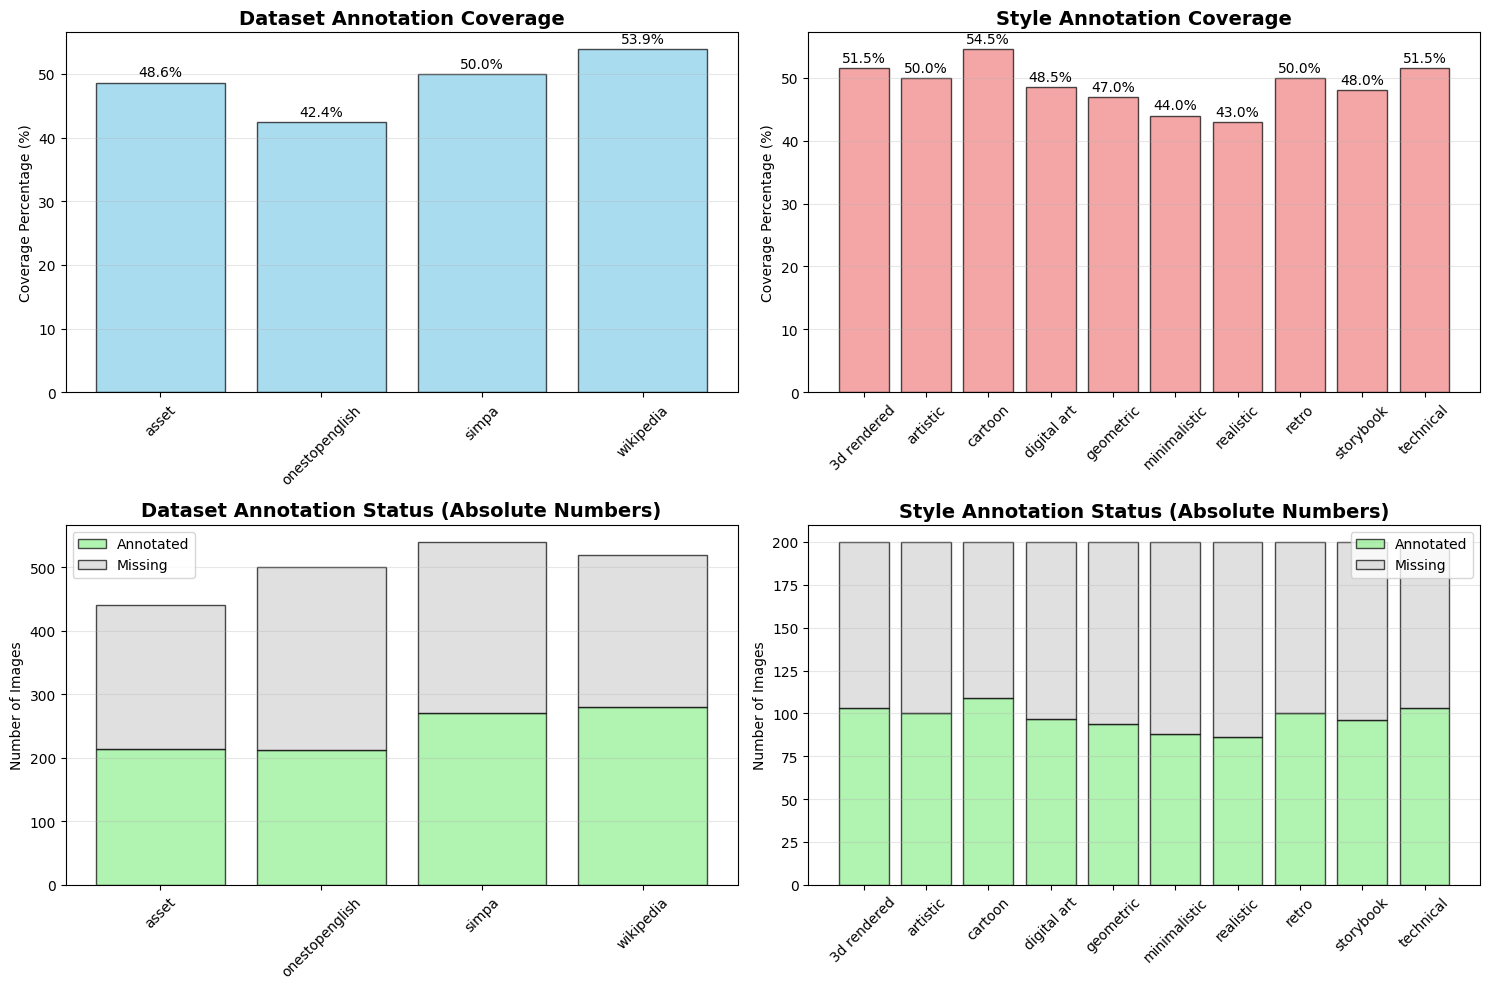


POTENTIAL BIAS ANALYSIS

DATASET BIAS ASSESSMENT:

Detected potential dataset bias:
+----------------+------------+-------------+-------------------+--------------------+
| Dataset        | Coverage   | Deviation   | Bias_Type         | Potential_Impact   |
+================+============+=============+===================+====================+
| onestopenglish | 42.4%      | -6.3%       | Under-represented | Medium             |
+----------------+------------+-------------+-------------------+--------------------+
| wikipedia      | 53.9%      | +5.1%       | Over-represented  | Medium             |
+----------------+------------+-------------+-------------------+--------------------+

STYLE BIAS ASSESSMENT:

Detected potential style bias:
+-----------+------------+-------------+-------------------+--------------------+
| Style     | Coverage   | Deviation   | Bias_Type         | Potential_Impact   |
+===========+============+=============+===================+====================+
| ca

In [2]:
"""
Annotation Distribution Analysis by Dataset and Style
===================================================

This script analyzes the actual distribution of annotated image-text pairs
across datasets and styles to identify potential bias in the evaluation results.

Key Features:
- Counts actual annotations vs. available pairs by dataset
- Counts actual annotations vs. available pairs by style
- Calculates annotation coverage percentages
- Identifies potential bias from uneven sampling
- Compares expert-specific annotation patterns

Author: Distribution Analysis
Date: June 2025
"""

import json
import pandas as pd
import numpy as np
from pathlib import Path
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURATION
# ============================================================================

# File paths
ANNOTATION_DIR = r"C:\Users\SouayedBelkiss\OneDrive - gae\Desktop\Thesis\annotation_analysis\expert work"
MAPPING_DIR = r"C:\Users\SouayedBelkiss\OneDrive - gae\Desktop\Thesis\annotation_analysis\required files"

# File mappings
ANNOTATION_FILES = {
    'Expert_A': 'alexa_annotations.json',
    'Expert_K': 'katrin_annotations.json', 
    'Expert_L': 'luisa_annotations.json',
    'Expert_M': 'martin_annotations.json'
}

MAPPING_FILE = 'renamed_images_mapping.csv'

# Known categories
KNOWN_STYLES = [
    '3d rendered', 'artistic', 'cartoon', 'digital art', 'geometric',
    'minimalistic', 'realistic', 'retro', 'storybook', 'technical'
]

# ============================================================================
# DATA LOADING FUNCTIONS
# ============================================================================

def load_full_mapping():
    """Load the complete CSV mapping to see all available pairs."""
    print("Loading complete dataset mapping...")
    
    mapping_path = Path(MAPPING_DIR) / MAPPING_FILE
    
    try:
        df_mapping = pd.read_csv(mapping_path)
        print(f"✓ Total available image-text pairs: {len(df_mapping)}")
        
        return df_mapping
        
    except Exception as e:
        print(f"✗ ERROR loading mapping: {e}")
        return None

def load_all_annotations():
    """Load all expert annotations with image mapping."""
    print("\nLoading all expert annotations...")
    
    all_annotations = []
    expert_stats = {}
    
    for expert_name, filename in ANNOTATION_FILES.items():
        filepath = Path(ANNOTATION_DIR) / filename
        
        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                data = json.load(f)
            
            expert_annotations = []
            for record in data:
                if record['annotations']:
                    image_filename = record['data'].get('original_filename', 'unknown')
                    expert_annotations.append({
                        'expert': expert_name,
                        'image': image_filename,
                        'annotation_exists': True
                    })
            
            all_annotations.extend(expert_annotations)
            expert_stats[expert_name] = len(expert_annotations)
            print(f"  {expert_name}: {len(expert_annotations)} annotations")
            
        except Exception as e:
            print(f"✗ ERROR loading {filename}: {e}")
            expert_stats[expert_name] = 0
    
    print(f"\nTotal annotations across all experts: {len(all_annotations)}")
    return pd.DataFrame(all_annotations), expert_stats

# ============================================================================
# DISTRIBUTION ANALYSIS FUNCTIONS
# ============================================================================

def analyze_dataset_annotation_coverage(df_mapping, df_annotations):
    """Analyze annotation coverage by dataset."""
    print(f"\n{'='*80}")
    print("DATASET ANNOTATION COVERAGE ANALYSIS")
    print(f"{'='*80}")
    
    # Get all available pairs by dataset
    dataset_totals = df_mapping['dataset'].value_counts().sort_index()
    
    # Create lookup for image to dataset mapping
    image_to_dataset = {}
    for _, row in df_mapping.iterrows():
        image_to_dataset[row['new_filename']] = row['dataset']
    
    # Map annotations to datasets
    def get_dataset_for_annotation(image_filename):
        # Handle _IAA images
        base_filename = image_filename.replace('_IAA', '')
        return image_to_dataset.get(base_filename, 'unknown')
    
    df_annotations['dataset'] = df_annotations['image'].apply(get_dataset_for_annotation)
    
    # Filter out unknown mappings
    valid_annotations = df_annotations[df_annotations['dataset'] != 'unknown']
    
    # Count annotations by dataset
    annotated_counts = valid_annotations['dataset'].value_counts().sort_index()
    
    # Create coverage analysis
    coverage_data = []
    
    for dataset in dataset_totals.index:
        total_available = dataset_totals[dataset]
        annotated = annotated_counts.get(dataset, 0)
        coverage_pct = (annotated / total_available) * 100
        
        coverage_data.append({
            'Dataset': dataset,
            'Total_Available': total_available,
            'Annotated': annotated,
            'Coverage_%': coverage_pct,
            'Missing': total_available - annotated
        })
    
    coverage_df = pd.DataFrame(coverage_data)
    coverage_df = coverage_df.round(2)
    
    print("\nDATASET ANNOTATION COVERAGE:")
    print(tabulate(coverage_df, headers='keys', tablefmt='grid', showindex=False))
    
    # Calculate statistics
    mean_coverage = coverage_df['Coverage_%'].mean()
    std_coverage = coverage_df['Coverage_%'].std()
    min_coverage = coverage_df['Coverage_%'].min()
    max_coverage = coverage_df['Coverage_%'].max()
    
    print(f"\nCOVERAGE STATISTICS:")
    print(f"  Mean coverage: {mean_coverage:.1f}%")
    print(f"  Standard deviation: {std_coverage:.1f}%")
    print(f"  Range: {min_coverage:.1f}% - {max_coverage:.1f}%")
    print(f"  Coverage spread: {max_coverage - min_coverage:.1f} percentage points")
    
    return coverage_df

def analyze_style_annotation_coverage(df_mapping, df_annotations):
    """Analyze annotation coverage by visual style."""
    print(f"\n{'='*80}")
    print("VISUAL STYLE ANNOTATION COVERAGE ANALYSIS")
    print(f"{'='*80}")
    
    # Get all available pairs by style
    style_totals = df_mapping['style'].value_counts().sort_index()
    
    # Create lookup for image to style mapping
    image_to_style = {}
    for _, row in df_mapping.iterrows():
        image_to_style[row['new_filename']] = row['style']
    
    # Map annotations to styles
    def get_style_for_annotation(image_filename):
        # Handle _IAA images
        base_filename = image_filename.replace('_IAA', '')
        return image_to_style.get(base_filename, 'unknown')
    
    df_annotations['style'] = df_annotations['image'].apply(get_style_for_annotation)
    
    # Filter out unknown mappings
    valid_annotations = df_annotations[df_annotations['style'] != 'unknown']
    
    # Count annotations by style
    annotated_counts = valid_annotations['style'].value_counts().sort_index()
    
    # Create coverage analysis
    coverage_data = []
    
    for style in style_totals.index:
        total_available = style_totals[style]
        annotated = annotated_counts.get(style, 0)
        coverage_pct = (annotated / total_available) * 100
        
        coverage_data.append({
            'Style': style,
            'Total_Available': total_available,
            'Annotated': annotated,
            'Coverage_%': coverage_pct,
            'Missing': total_available - annotated
        })
    
    coverage_df = pd.DataFrame(coverage_data)
    coverage_df = coverage_df.round(2)
    
    print("\nVISUAL STYLE ANNOTATION COVERAGE:")
    print(tabulate(coverage_df, headers='keys', tablefmt='grid', showindex=False))
    
    # Calculate statistics
    mean_coverage = coverage_df['Coverage_%'].mean()
    std_coverage = coverage_df['Coverage_%'].std()
    min_coverage = coverage_df['Coverage_%'].min()
    max_coverage = coverage_df['Coverage_%'].max()
    
    print(f"\nCOVERAGE STATISTICS:")
    print(f"  Mean coverage: {mean_coverage:.1f}%")
    print(f"  Standard deviation: {std_coverage:.1f}%")
    print(f"  Range: {min_coverage:.1f}% - {max_coverage:.1f}%")
    print(f"  Coverage spread: {max_coverage - min_coverage:.1f} percentage points")
    
    return coverage_df

def analyze_expert_specific_patterns(df_mapping, df_annotations):
    """Analyze annotation patterns by individual experts."""
    print(f"\n{'='*80}")
    print("EXPERT-SPECIFIC ANNOTATION PATTERNS")
    print(f"{'='*80}")
    
    # Create mapping lookups
    image_to_dataset = {}
    image_to_style = {}
    for _, row in df_mapping.iterrows():
        image_to_dataset[row['new_filename']] = row['dataset']
        image_to_style[row['new_filename']] = row['style']
    
    # Map annotations to categories
    def get_categories_for_annotation(image_filename):
        base_filename = image_filename.replace('_IAA', '')
        dataset = image_to_dataset.get(base_filename, 'unknown')
        style = image_to_style.get(base_filename, 'unknown')
        return dataset, style
    
    df_annotations[['dataset', 'style']] = df_annotations['image'].apply(
        lambda x: pd.Series(get_categories_for_annotation(x))
    )
    
    # Filter valid annotations
    valid_annotations = df_annotations[
        (df_annotations['dataset'] != 'unknown') & 
        (df_annotations['style'] != 'unknown')
    ]
    
    print("\nEXPERT ANNOTATION DISTRIBUTION BY DATASET:")
    dataset_expert_crosstab = pd.crosstab(
        valid_annotations['dataset'], 
        valid_annotations['expert'], 
        margins=True
    )
    print(tabulate(dataset_expert_crosstab, headers='keys', tablefmt='grid'))
    
    print("\nEXPERT ANNOTATION DISTRIBUTION BY STYLE:")
    style_expert_crosstab = pd.crosstab(
        valid_annotations['style'], 
        valid_annotations['expert'], 
        margins=True
    )
    print(tabulate(style_expert_crosstab, headers='keys', tablefmt='grid'))
    
    return dataset_expert_crosstab, style_expert_crosstab

def create_coverage_visualization(dataset_coverage, style_coverage):
    """Create visualizations for coverage analysis."""
    print(f"\n{'='*80}")
    print("CREATING COVERAGE VISUALIZATIONS")
    print(f"{'='*80}")
    
    # Set up the plotting style
    plt.style.use('default')
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Dataset coverage bar chart
    ax1.bar(dataset_coverage['Dataset'], dataset_coverage['Coverage_%'], 
            color='skyblue', alpha=0.7, edgecolor='black')
    ax1.set_title('Dataset Annotation Coverage', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Coverage Percentage (%)')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, v in enumerate(dataset_coverage['Coverage_%']):
        ax1.text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom')
    
    # Style coverage bar chart
    ax2.bar(style_coverage['Style'], style_coverage['Coverage_%'], 
            color='lightcoral', alpha=0.7, edgecolor='black')
    ax2.set_title('Style Annotation Coverage', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Coverage Percentage (%)')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, v in enumerate(style_coverage['Coverage_%']):
        ax2.text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom')
    
    # Dataset absolute numbers
    ax3.bar(dataset_coverage['Dataset'], dataset_coverage['Annotated'], 
            color='lightgreen', alpha=0.7, edgecolor='black', label='Annotated')
    ax3.bar(dataset_coverage['Dataset'], dataset_coverage['Missing'], 
            bottom=dataset_coverage['Annotated'], color='lightgray', alpha=0.7, 
            edgecolor='black', label='Missing')
    ax3.set_title('Dataset Annotation Status (Absolute Numbers)', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Number of Images')
    ax3.tick_params(axis='x', rotation=45)
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)
    
    # Style absolute numbers
    ax4.bar(style_coverage['Style'], style_coverage['Annotated'], 
            color='lightgreen', alpha=0.7, edgecolor='black', label='Annotated')
    ax4.bar(style_coverage['Style'], style_coverage['Missing'], 
            bottom=style_coverage['Annotated'], color='lightgray', alpha=0.7, 
            edgecolor='black', label='Missing')
    ax4.set_title('Style Annotation Status (Absolute Numbers)', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Number of Images')
    ax4.tick_params(axis='x', rotation=45)
    ax4.legend()
    ax4.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('annotation_coverage_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

def identify_potential_bias(dataset_coverage, style_coverage):
    """Identify potential bias from uneven annotation coverage."""
    print(f"\n{'='*80}")
    print("POTENTIAL BIAS ANALYSIS")
    print(f"{'='*80}")
    
    print("\nDATASET BIAS ASSESSMENT:")
    dataset_bias_issues = []
    
    mean_dataset_coverage = dataset_coverage['Coverage_%'].mean()
    
    for _, row in dataset_coverage.iterrows():
        deviation = row['Coverage_%'] - mean_dataset_coverage
        if abs(deviation) > 5:  # More than 5% deviation from mean
            bias_type = "Over-represented" if deviation > 0 else "Under-represented"
            dataset_bias_issues.append({
                'Dataset': row['Dataset'],
                'Coverage': f"{row['Coverage_%']:.1f}%",
                'Deviation': f"{deviation:+.1f}%",
                'Bias_Type': bias_type,
                'Potential_Impact': 'High' if abs(deviation) > 10 else 'Medium'
            })
    
    if dataset_bias_issues:
        print("\nDetected potential dataset bias:")
        bias_df = pd.DataFrame(dataset_bias_issues)
        print(tabulate(bias_df, headers='keys', tablefmt='grid', showindex=False))
    else:
        print("No significant dataset bias detected (all within 5% of mean coverage)")
    
    print("\nSTYLE BIAS ASSESSMENT:")
    style_bias_issues = []
    
    mean_style_coverage = style_coverage['Coverage_%'].mean()
    
    for _, row in style_coverage.iterrows():
        deviation = row['Coverage_%'] - mean_style_coverage
        if abs(deviation) > 5:  # More than 5% deviation from mean
            bias_type = "Over-represented" if deviation > 0 else "Under-represented"
            style_bias_issues.append({
                'Style': row['Style'],
                'Coverage': f"{row['Coverage_%']:.1f}%",
                'Deviation': f"{deviation:+.1f}%",
                'Bias_Type': bias_type,
                'Potential_Impact': 'High' if abs(deviation) > 10 else 'Medium'
            })
    
    if style_bias_issues:
        print("\nDetected potential style bias:")
        bias_df = pd.DataFrame(style_bias_issues)
        print(tabulate(bias_df, headers='keys', tablefmt='grid', showindex=False))
    else:
        print("No significant style bias detected (all within 5% of mean coverage)")
    
    return dataset_bias_issues, style_bias_issues

# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    """Main function to run the complete annotation distribution analysis."""
    print("="*80)
    print("ANNOTATION DISTRIBUTION ANALYSIS")
    print("="*80)
    print("Analyzing actual annotation coverage vs. available image-text pairs")
    
    # Load data
    df_mapping = load_full_mapping()
    if df_mapping is None:
        return None
    
    df_annotations, expert_stats = load_all_annotations()
    if df_annotations is None or len(df_annotations) == 0:
        print("ERROR: No annotation data loaded")
        return None
    
    # Analyze coverage by dataset
    dataset_coverage = analyze_dataset_annotation_coverage(df_mapping, df_annotations)
    
    # Analyze coverage by style
    style_coverage = analyze_style_annotation_coverage(df_mapping, df_annotations)
    
    # Analyze expert-specific patterns
    dataset_expert_crosstab, style_expert_crosstab = analyze_expert_specific_patterns(
        df_mapping, df_annotations
    )
    
    # Create visualizations
    create_coverage_visualization(dataset_coverage, style_coverage)
    
    # Identify potential bias
    dataset_bias, style_bias = identify_potential_bias(dataset_coverage, style_coverage)
    
    print(f"\n{'='*80}")
    print("ANNOTATION DISTRIBUTION ANALYSIS COMPLETE!")
    print(f"{'='*80}")
    print("Results stored in variables:")
    print("• dataset_coverage: Dataset annotation coverage analysis")
    print("• style_coverage: Style annotation coverage analysis") 
    print("• dataset_expert_crosstab: Expert distribution by dataset")
    print("• style_expert_crosstab: Expert distribution by style")
    print("• dataset_bias: Potential dataset bias issues")
    print("• style_bias: Potential style bias issues")
    
    return {
        'dataset_coverage': dataset_coverage,
        'style_coverage': style_coverage,
        'dataset_expert_crosstab': dataset_expert_crosstab,
        'style_expert_crosstab': style_expert_crosstab,
        'dataset_bias': dataset_bias,
        'style_bias': style_bias,
        'expert_stats': expert_stats
    }

# ============================================================================
# EXECUTION
# ============================================================================

if __name__ == "__main__":
    distribution_results = main()